In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import dopioe, compute_tilt_data, bearing, ellipse_aspect_ratio

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,q11,q12,q22,Rc,psi0,A,R,Age,Date,fname
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,1.099922,-0.193920,0.943344,104.677927,71.391686,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,1.066764,-0.119714,0.950849,110.542281,77.351002,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,1.016800,-0.154298,1.006892,115.245476,75.250400,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,0.896874,-0.276325,1.200119,114.738549,72.789618,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,0.847358,-0.169788,1.214160,100.425496,58.705551,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,0.898473,0.197470,1.156400,114.894173,-41.491437,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,0.884289,0.308226,1.238286,111.853372,-42.195517,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,0.883521,0.168561,1.163994,107.180060,-43.102690,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,0.873263,0.225002,1.203104,100.368133,-37.967048,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...


In [15]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
# f = np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [16]:
ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)

# compute bin indices
df_eddies['ix'] = np.digitize(df_eddies.xc, x_edges) - 1   # 0..ncols-1
df_eddies['iy'] = np.digitize(df_eddies.yc, y_edges) - 1   # 0..nrows-1

# remove out-of-range bins
df_eddies.loc[(df_eddies.ix < 0) | (df_eddies.ix >= ncols), 'ix'] = np.nan
df_eddies.loc[(df_eddies.iy < 0) | (df_eddies.iy >= nrows), 'iy'] = np.nan

# column labels (A,B,C,...)
col_labels = np.array(['A','B','C','D'])[:ncols]

# create "A1", "C4", etc.
mask = df_eddies.ix.notna() & df_eddies.iy.notna()
df_eddies.loc[mask, 'cell_label'] = (
    col_labels[df_eddies.loc[mask, 'ix'].astype(int)] +
    (df_eddies.loc[mask, 'iy'].astype(int) + 1).astype(str).values
)

df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,...,Rc,psi0,A,R,Age,Date,fname,ix,iy,cell_label
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,...,104.677927,71.391686,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,1.0,3.0,B4
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,...,110.542281,77.351002,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,1.0,3.0,B4
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,...,115.245476,75.250400,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,1.0,3.0,B4
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,...,114.738549,72.789618,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,1.0,3.0,B4
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,...,100.425496,58.705551,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,1.0,3.0,B4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,...,114.894173,-41.491437,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,2.0,1.0,C2
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,...,111.853372,-42.195517,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,2.0,1.0,C2
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,...,107.180060,-43.102690,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,2.0,1.0,C2
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,...,100.368133,-37.967048,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,2.0,1.0,C2


Calculate there vertical centers

In [17]:
with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)


In [18]:
df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_tilt_data


,Eddy,Day,TiltDis,TiltDir
0,1,1465,31.669332,89.546110
1,1,1466,33.600109,92.955602
2,1,1467,35.159201,96.662951
3,1,1468,35.643445,101.070039
4,1,1469,34.916207,105.866105
...,...,...,...,...
89447,2631,10643,10.685422,350.104683
89448,2631,10644,10.055826,348.769338
89449,2631,10645,11.563679,343.688930
89450,2631,10646,12.848125,334.097803


In [19]:
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)
df_eddies


,Eddy,Day,Cyc,Lon,Lat,ic,jc,xc,yc,w,...,A,R,Age,Date,fname,ix,iy,cell_label,TiltDis,TiltDir
0,1,1462,CE,156.969773,-28.461100,179,274,505.897600,1353.012251,-0.000033,...,-0.006515,69.250036,57,1994-01-02,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,1.0,3.0,B4,NaN,NaN
1,1,1463,CE,156.993096,-28.433992,179,275,507.149717,1356.633687,-0.000030,...,-0.006330,62.000626,57,1994-01-03,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,1.0,3.0,B4,NaN,NaN
2,1,1464,CE,157.097940,-28.381485,181,276,515.130000,1365.650728,-0.000028,...,-0.005666,67.000485,57,1994-01-04,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,1.0,3.0,B4,NaN,NaN
3,1,1465,CE,157.094334,-28.315658,181,278,512.570772,1372.426342,-0.000033,...,-0.005529,66.501582,57,1994-01-05,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,1.0,3.0,B4,31.669332,89.546110
4,1,1466,CE,157.106324,-28.346479,181,277,514.728351,1369.599726,-0.000029,...,-0.005821,56.251116,57,1994-01-06,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,1.0,3.0,B4,33.600109,92.955602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105233,2631,10646,AE,157.825620,-37.030656,248,97,850.502045,476.447416,0.000013,...,0.003143,72.751791,24,2019-02-24,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,2.0,1.0,C2,12.848125,334.097803
105234,2631,10647,AE,157.880796,-36.972725,249,98,853.608024,484.316677,0.000014,...,0.003373,73.000933,24,2019-02-25,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,2.0,1.0,C2,13.627106,324.784689
105235,2631,10648,AE,157.868516,-36.874363,248,100,849.759258,494.400614,0.000014,...,0.003752,75.750780,24,2019-02-26,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,2.0,1.0,C2,NaN,NaN
105236,2631,10649,AE,157.753058,-36.882303,246,99,840.037603,489.981707,0.000013,...,0.003769,75.750006,24,2019-02-27,/srv/scratch/z3533156/26year_BRAN2020/outer_av...,2.0,1.0,C2,NaN,NaN


In [10]:
num_profiles = len(df_eddies)-6*len(df_eddies.Eddy.unique())
print(f'Total No. of used profiles: {num_profiles}')
num_tilt_profiles = np.sum(~np.isnan(df_eddies.TiltDis))
print(f'Total No. of profiles tilt measured: {num_tilt_profiles}')
print(f'Tilt measuring success rate: {num_tilt_profiles/num_profiles}')


Total No. of used profiles: 89452
Total No. of profiles tilt measured: 74946
Tilt measuring success rate: 0.8378348164378662


In [11]:
df_tilt_data_clean = df_tilt_data.dropna().copy()
num_prof_TD_blw_40 = np.sum(df_tilt_data_clean.TiltDis <= 40) / num_tilt_profiles
print(f'No. Profiles below 40km TD: {num_prof_TD_blw_40}')
print(f'Max TD {df_tilt_data_clean.TiltDis.max()}')


No. Profiles below 40km TD: 0.857230539321645
Max TD 168.39160737980941


#### Additional Data

In [12]:
def coriolis(lat_deg):
    Omega = 7.2921e-5  # Earth's rotation rate [rad/s]
    return 2 * Omega * np.sin(np.deg2rad(lat_deg))
df_eddies['f'] = coriolis(df_eddies.Lat)

day_idxs = []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    if len(df):
        day_idxs.extend(df.Day-df.Day.iloc[0])
df_eddies['Day_idx'] = day_idxs

norm_time = []
for eddy in df_eddies.Eddy.unique():
    seg = df_eddies[df_eddies.Eddy == eddy]
    n = len(seg)
    norm_time.extend(np.arange(n) / n)
df_eddies['norm_time'] = norm_time

eddy_props = []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    eddy_props.extend(np.array(np.hypot(df.xc.diff(), df.yc.diff()) * 0.011574))
df_eddies['EddyProp'] = eddy_props

# bottom of eddy propogation
df_idx = df_eddies.set_index(['Eddy', 'Day'])
eddy_btm_prop = []
for eddy, dic in dic_eddies_vert.items():
    x_btms, y_btms = [], []
    eddy_id = int(eddy[4:])
    for day, df in dic.items():
        if len(df):
            data = df.iloc[-1]
            xc, yc = data.x, data.y
        else:
            day_id = int(day[3:])
            data = df_idx.loc[(eddy_id, day_id)]
            xc, yc = data.xc, data.yc
        x_btms.append(xc)
        y_btms.append(yc)
    disp = np.hypot(np.diff(x_btms), np.diff(y_btms)) * 0.011574
    disp = np.insert(disp, 0, np.nan)   # add NaN at the start
    eddy_btm_prop.extend(disp)
df_eddies['btm_prop'] = eddy_btm_prop

ARs = []
for k in range(len(df_eddies)):
    data = df_eddies.iloc[k]
    ARs.append(ellipse_aspect_ratio(data.q11, data.q12, data.q22))
df_eddies['AR'] = ARs

hs = []
for k in range(len(df_eddies)):
    data = df_eddies.iloc[k]
    hs.append(h[data.ic, data.jc])
df_eddies['h'] = hs

def slope_mag(h, X, Y, mask=None):
    # derivatives wrt index space (i, j)
    x_i, x_j = np.gradient(X)
    y_i, y_j = np.gradient(Y)
    h_i, h_j = np.gradient(h)
    # Jacobian and physical-space gradients
    J = x_i*y_j - x_j*y_i
    dhdx = ( h_i*y_j - h_j*y_i) / J
    dhdy = (-h_i*x_j + h_j*x_i) / J
    S = np.hypot(dhdx, dhdy)          # slope magnitude = tan(theta)
    S[np.isclose(J, 0)] = np.nan       # guard against singular cells
    if mask is not None:               # mask: 1=ocean, 0=land
        S = np.where(mask.astype(bool), S, np.nan)
    return S
s = slope_mag(h/1e3, X_grid, Y_grid, mask=mask_rho)
df_eddies['s'] = s[df_eddies.ic, df_eddies.jc]

# Burger Number
H = 300
Nbar_ave = np.load('/srv/scratch/z5297792/Climatology/N2s/Nbar_300m_ave.npy')
f = np.transpose(dataset.variables['f'], axes=(1, 0))
Bu = ( (Nbar_ave * H) / (f * 50000) )**2
Bu = np.where(mask_rho, Bu, np.nan)
Bu = np.where(h > H, Bu, np.nan)
Bus = []
for k in range(len(df_eddies)):
    data = df_eddies.iloc[k]
    Bus.append(Bu[data.ic, data.jc])
df_eddies['Bu'] = Bus

df_AE = df_eddies[df_eddies.Cyc=='AE'].copy()
df_CE = df_eddies[df_eddies.Cyc=='CE'].copy()

df_AE_ = df_eddies[df_eddies.Cyc=='AE'].copy().dropna()
df_CE_ = df_eddies[df_eddies.Cyc=='CE'].copy().dropna()

print(f'AE TD Mean: {round(df_AE.TiltDis.mean())}km')
print(f'CE TD Mean: {round(df_CE.TiltDis.mean())}km')


AE TD Mean: 24km
CE TD Mean: 21km


### Latitude Analysis

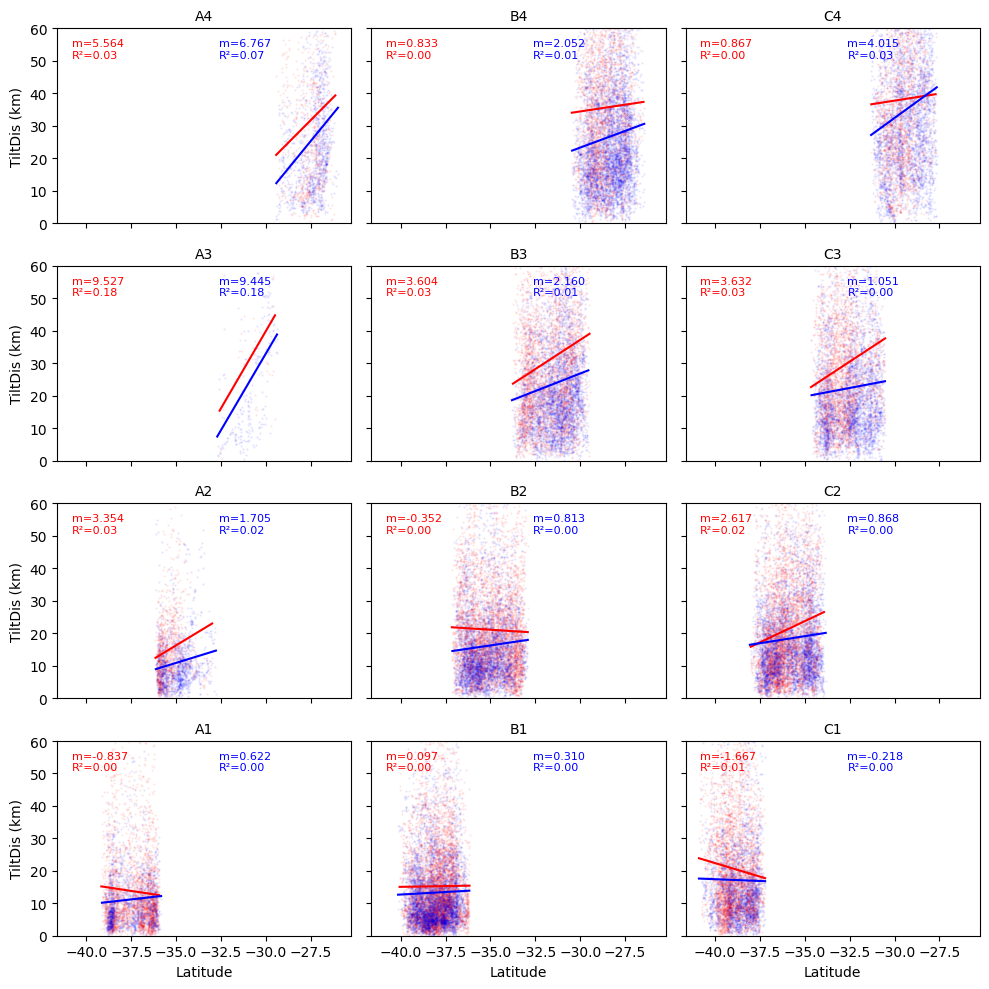

In [28]:
from scipy.stats import linregress

fig, axs = plt.subplots(4, 3, figsize=(10, 10), sharex=True, sharey=True)

cols = ['A', 'B', 'C']
rows = [4, 3, 2, 1]  # top to bottom
clrs = ['r', 'b']
for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ax = axs[i, j]
        lab = f'{col}{row}'
        sub_all = df_eddies[df_eddies.cell_label == lab].dropna(subset=['TiltDis', 'Lat'])

        for s, sub in enumerate([sub_all[sub_all.Cyc=='AE'], sub_all[sub_all.Cyc=='CE']]):
    
            if len(sub) > 1:
                x = sub.Lat.values
                y = sub.TiltDis.values
    
                slope, intercept, r, p, std_err = linregress(x, y)
    
                ax.scatter(x, y, s=1, marker='.', alpha=.1, color=clrs[s])
                xx = np.linspace(x.min(), x.max(), 50)
                ax.plot(xx, slope*xx + intercept, color=clrs[s])
    
                ax.text(
                    0.05 + s*.5, 0.95,
                    f"m={slope:.3f}\nR²={r**2:.2f}",
                    transform=ax.transAxes, color=clrs[s],
                    ha='left', va='top', fontsize=8
                )

        ax.set_title(lab, fontsize=10)

for ax in axs[-1, :]:
    ax.set_xlabel('Latitude')
    ax.set_ylim(0, 60)
for ax in axs[:, 0]:
    ax.set_ylabel('TiltDis (km)')

plt.tight_layout()
plt.show()


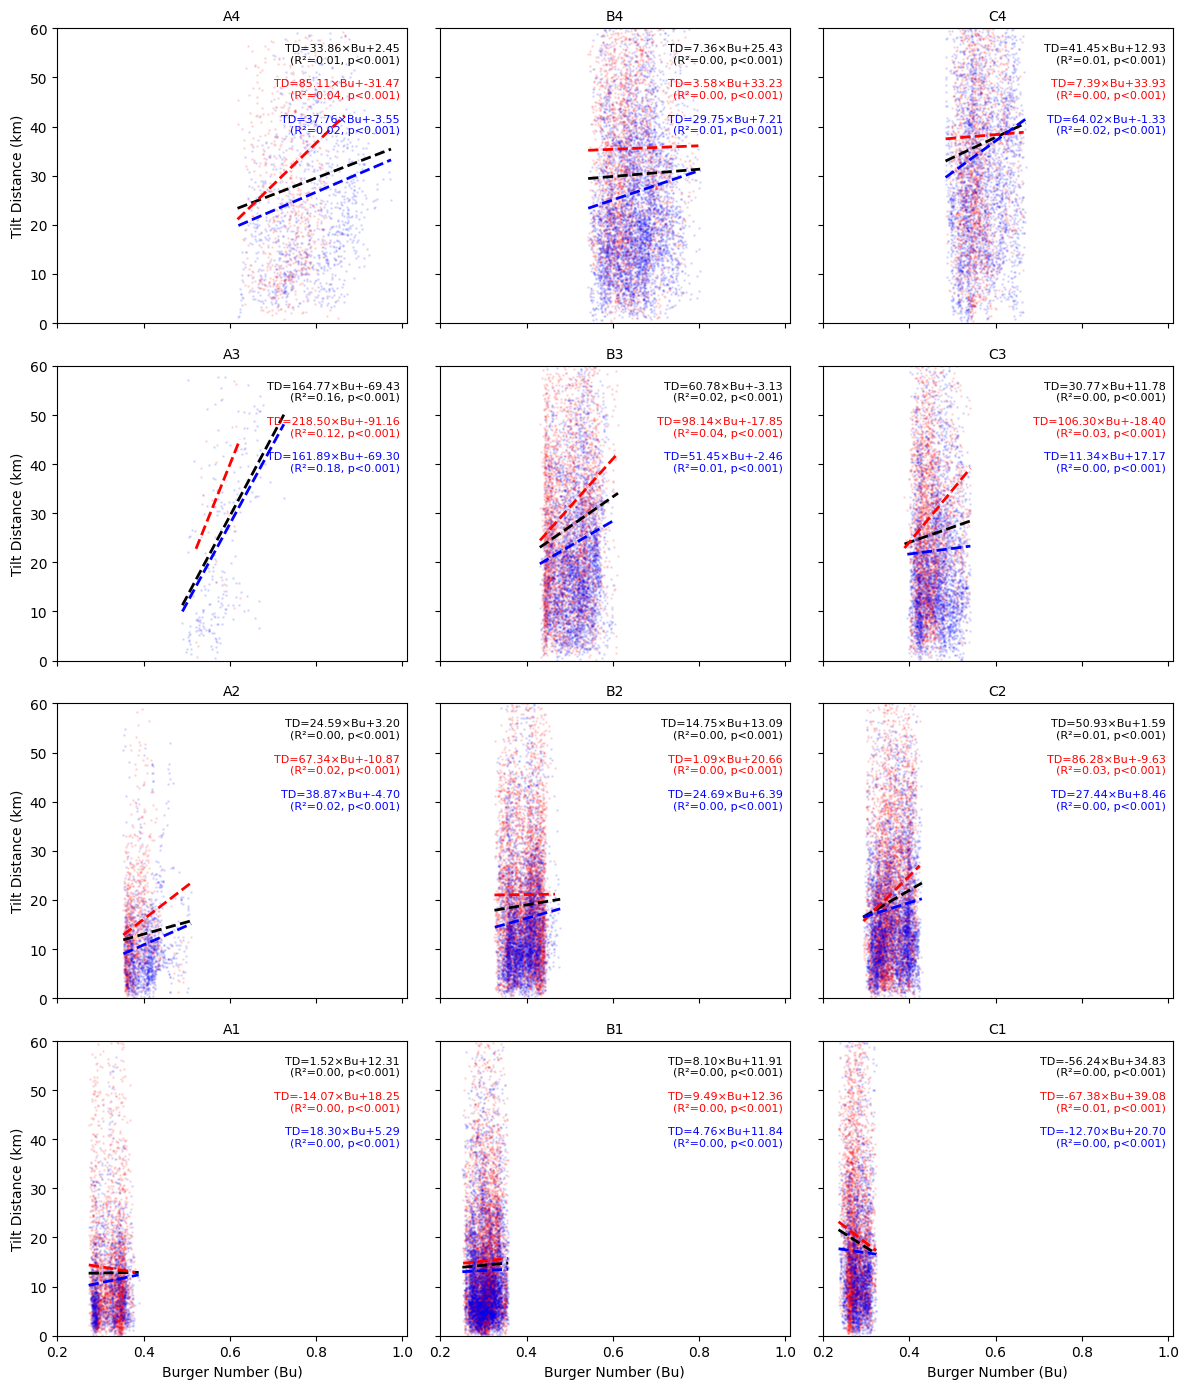

In [38]:
from scipy.stats import linregress

rows = [4, 3, 2, 1]          # top → bottom
cols = ['A', 'B', 'C']       # left → right

clrs = ['k', 'r', 'b']
labels = ['AE & CE', 'AE', 'CE']

fig, axs = plt.subplots(4, 3, figsize=(12, 14), sharex=True, sharey=True)

for i, row in enumerate(rows):
    for j, col in enumerate(cols):
        ax = axs[i, j]

        lab = f"{col}{row}"
        ax.set_title(lab, fontsize=10)

        df_all = df_eddies[df_eddies.cell_label == lab]
        df_AE  = df_all[df_all.Cyc == 'AE']
        df_CE  = df_all[df_all.Cyc == 'CE']

        dfs = [df_all, df_AE, df_CE]

        for k, df in enumerate(dfs):

            if len(df) < 2:
                continue

            x = df.Bu.values
            y = df.TiltDis.values

            mask = ~np.isnan(x) & ~np.isnan(y)
            x = x[mask]
            y = y[mask]

            if len(x) < 2:
                continue

            res = linregress(x, y)
            slope, intercept = res.slope, res.intercept
            r2, p = res.rvalue**2, res.pvalue

            # scatter only for AE&CE
            if k != 0:
                ax.scatter(x, y, s=1, alpha=.1, color=clrs[k])

            # regression line
            idx = np.argsort(x)
            xs = x[idx]
            ax.plot(xs, slope*xs + intercept,
                    color=colors[k], lw=2, ls='--')

            # text annotation (same format as your original)
            ax.text(
                0.98, 0.95 - 0.12*k,
                fr"TD={slope:.2f}×Bu+{intercept:.2f}"
                f"\n(R²={r2:.2f}, p<0.001)",
                ha='right', va='top',
                color=colors[k], transform=ax.transAxes, fontsize=8
            )

# axis labels
for ax in axs[-1, :]:
    ax.set_xlabel('Burger Number (Bu)')
    ax.set_ylim(0, 60)
for ax in axs[:, 0]:
    ax.set_ylabel('Tilt Distance (km)')

plt.tight_layout()
plt.show()


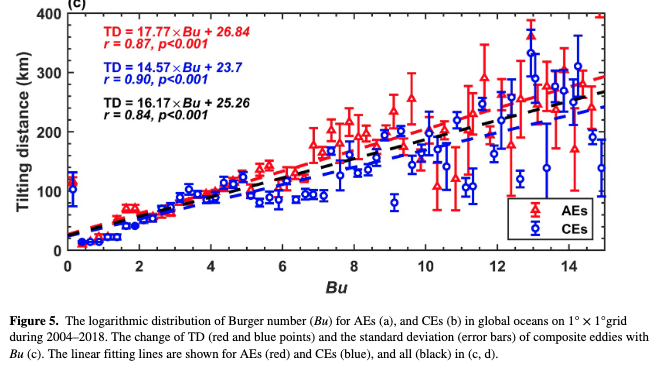





### Time Analysis

In [ ]:
titles = ['ALL', 'AE', 'CE']
clrs = ['k', 'r', 'b']
for d, df_data in enumerate([df_eddies, df_AE, df_CE]):
    df_list = []
    for eddy in df_data.Eddy.unique():
        seg = df_data[df_data.Eddy == eddy]
        df_list.append(pd.DataFrame({
            'x': seg.norm_time,
            'y': seg.TiltDis
        }))
    
    df = pd.concat(df_list, ignore_index=True).dropna()
    x, y = df.x.values, df.y.values

    slope, intercept, r, p, err = linregress(x, y)
    print(f'{titles[d]}')
    print(f"Slope: {slope}")
    print(f"Intercept: {intercept}")
    print(f"R²: {r**2}")
    print(f"p-value: {p}")
    print(f"Standard error: {err}")

    if d == 0:
        plt.scatter(x, y, s=1, marker='.', alpha=.3)
    plt.plot(x, slope * x + intercept, color=clrs[d], label=f'{titles[d]}')

    txt = fr"TD = {slope:.2f}$\times$t + {intercept:.2f}  (R²={r2:.2f}, p={p:.4e})"
    plt.text(0.78, 0.98 - .05*d, txt, ha='right', va='top', fontweight='bold',
             color=clrs[d], transform=plt.gca().transAxes)

plt.ylim(0, 60); plt.legend(); plt.title('All Ages'); plt.grid(True)
plt.xlabel('Normalised Time'); plt.ylabel('Tilt Distance (km)')


In [ ]:
age_stops = list(np.arange(0, 151, 10)) + [500]

rows = []

for cyc_label, df_data in zip(['AE', 'CE'], [df_AE, df_CE]):
    for i, age1 in enumerate(age_stops):
        for age2 in age_stops[i+1:]:

            # enforce minimum width of 50 days
            if age2 - age1 < 50:
                continue

            sub = df_data[
                (df_data.Age >= age1) &
                (df_data.Age < age2)
            ][['Age', 'TiltDis', 'norm_time']].dropna()

            if len(sub) < 2:
                continue

            slope, intercept, r, p, err = linregress(
                sub.norm_time.values,
                sub.TiltDis.values
            )

            rows.append({
                'Cyc': cyc_label,
                'age1': age1,
                'age2': age2,
                'slope': slope,
                'intercept': intercept,
                'R2': r**2,
                'p': p,
                'err': err
            })

df_tilt_age_ints = pd.DataFrame(rows)
df_tilt_age_ints = df_tilt_age_ints[df_tilt_age_ints.age1 <= 100]
df_tilt_age_ints


In [ ]:
# Find max and min slopes
df_tilt_age_ints_AE = df_tilt_age_ints[df_tilt_age_ints.Cyc=='AE'].copy()
max_AE_slope = df_tilt_age_ints_AE.iloc[df_tilt_age_ints_AE.slope.abs().argmax()]
min_AE_slope = df_tilt_age_ints_AE.iloc[df_tilt_age_ints_AE.slope.abs().argmin()]

df_tilt_age_ints_CE = df_tilt_age_ints[df_tilt_age_ints.Cyc=='CE'].copy()
max_CE_slope = df_tilt_age_ints_CE.iloc[df_tilt_age_ints_CE.slope.abs().argmax()]
min_CE_slope = df_tilt_age_ints_CE.iloc[df_tilt_age_ints_CE.slope.abs().argmin()]


In [ ]:
bin_width = 0.05  # adjust if you want finer/coarser bins

titles = ['AE', 'CE']
clrs = ['r', 'b']

for d, df_data in enumerate([df_AE, df_CE]):
    df_list = []
    for eddy in df_data.Eddy.unique():
        seg = df_data[df_data.Eddy == eddy]
        if seg.Cyc.iloc[0] == 'AE':
            if (seg.Age.iloc[0] >= max_AE_slope.age1) & (seg.Age.iloc[0] <= max_AE_slope.age2):
                df_list.append(pd.DataFrame({'x': seg.norm_time, 'y': seg.TiltDis}))
        else:
            if (seg.Age.iloc[0] >= max_CE_slope.age1) & (seg.Age.iloc[0] <= max_CE_slope.age2):
                df_list.append(pd.DataFrame({'x': seg.norm_time, 'y': seg.TiltDis}))
    
    df = pd.concat(df_list, ignore_index=True).dropna()
    x, y = df.x.values, df.y.values

    slope, intercept, r, p, err = linregress(x, y)
    r2 = r**2
    print(f'{titles[d]}')
    print(f"Slope: {slope}")
    print(f"Intercept: {intercept}")
    print(f"R²: {r2}")
    print(f"p-value: {p}")
    print(f"Standard error: {err}")
   
    plt.scatter(x, y, s=1, marker='.', alpha=.1, color=clrs[d])
    plt.plot(x, slope * x + intercept, color=clrs[d], linestyle='--', label=f'{titles[d]} fit')

    # binned median in x (norm_time)
    bins = np.arange(df.x.min(), df.x.max() + bin_width, bin_width)
    df['bin'] = pd.cut(df.x, bins=bins, include_lowest=True)
    med = df.groupby('bin', observed=False).y.mean()
    x_med = [b.mid for b in med.index]
    plt.plot(x_med, med.values, lw=2, color=clrs[d], label=f'{titles[d]} mean')

    txt = fr"TD = {slope:.2f}$\times$t + {intercept:.2f}  (R²={r2:.2f}, p={p:.4e})"
    plt.text(0.78, 0.98 - .05*d, txt, ha='right', va='top', fontweight='bold',
             color=clrs[d], transform=plt.gca().transAxes)

plt.ylim(0, 30)
plt.legend(loc='lower right')
plt.grid(True)
plt.title(f'Max Slopes: AE {max_AE_slope.age1}-{max_AE_slope.age2} d.o., '
          f'CE {max_CE_slope.age1}-{max_CE_slope.age2} d.o.')
plt.xlabel('Normalised Time')
plt.ylabel('Tilt Distance (km)')







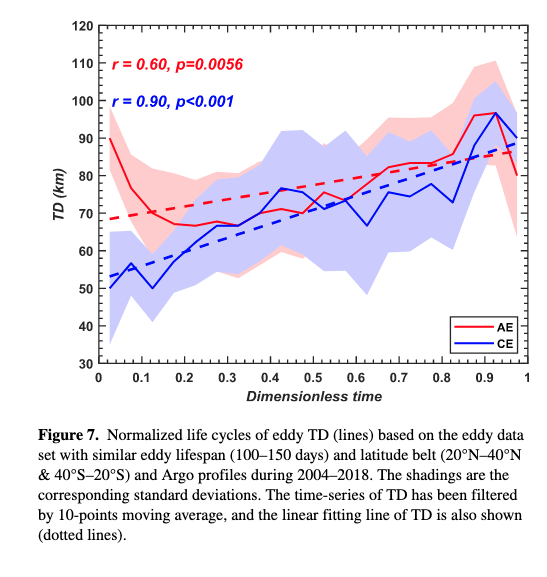

In [ ]:
titles = ['AE', 'CE']
clrs = ['r', 'b']
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greys')
axs[1].contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greys')
for d, df_data in enumerate([df_AE, df_CE]):
    df_list = []
    for eddy in df_data.Eddy.unique():
        seg = df_data[df_data.Eddy == eddy]
        if seg.Cyc.iloc[0] =='AE':
            if (seg.Age.iloc[0] >= max_AE_slope.age1) & (seg.Age.iloc[0] <= max_AE_slope.age2):
                axs[0].scatter(seg.xc, seg.yc, marker='.', s=1, c=seg.TiltDis, cmap='RdBu_r') #color=clrs[d])
        else:
            if (seg.Age.iloc[0] >= max_CE_slope.age1) & (seg.Age.iloc[0] <= max_CE_slope.age2):
                axs[1].scatter(seg.xc, seg.yc, marker='.', s=1, c=seg.TiltDis, cmap='RdBu_r')#, color=clrs[d])

axs[0].axis('equal'); axs[1].axis('equal')
axs[0].set_ylabel('y (km)');
axs[0].set_xlabel('x (km)'); axs[1].set_xlabel('x (km)');
plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.suptitle('Increasing TD Eddies')


In [ ]:
bin_width = 0.05  # adjust if you want finer/coarser bins

titles = ['AE', 'CE']
clrs = ['r', 'b']

for d, df_data in enumerate([df_AE, df_CE]):
    df_list = []
    for eddy in df_data.Eddy.unique():
        seg = df_data[df_data.Eddy == eddy]
        if seg.Cyc.iloc[0] == 'AE':
            if (seg.Age.iloc[0] >= min_AE_slope.age1) & (seg.Age.iloc[0] <= min_AE_slope.age2):
                df_list.append(pd.DataFrame({'x': seg.norm_time, 'y': seg.TiltDis}))
        else:
            if (seg.Age.iloc[0] >= min_CE_slope.age1) & (seg.Age.iloc[0] <= min_CE_slope.age2):
                df_list.append(pd.DataFrame({'x': seg.norm_time, 'y': seg.TiltDis}))
    
    df = pd.concat(df_list, ignore_index=True).dropna()
    x, y = df.x.values, df.y.values

    slope, intercept, r, p, err = linregress(x, y)
    r2 = r**2
    print(f'{titles[d]}')
    print(f"Slope: {slope}")
    print(f"Intercept: {intercept}")
    print(f"R²: {r2}")
    print(f"p-value: {p}")
    print(f"Standard error: {err}")
   
    plt.scatter(x, y, s=1, marker='.', alpha=.1, color=clrs[d])
    plt.plot(x, slope * x + intercept, color=clrs[d], linestyle='--', label=f'{titles[d]} fit')

    # binned median in x (norm_time)
    bins = np.arange(df.x.min(), df.x.max() + bin_width, bin_width)
    df['bin'] = pd.cut(df.x, bins=bins, include_lowest=True)
    med = df.groupby('bin', observed=False).y.mean()
    x_med = [b.mid for b in med.index]
    plt.plot(x_med, med.values, lw=2, color=clrs[d], label=f'{titles[d]} mean')

    txt = fr"TD = {slope:.2f}$\times$t + {intercept:.2f}  (R²={r2:.2f}, p={p:.4e})"
    plt.text(0.78, 0.98 - .05*d, txt, ha='right', va='top', fontweight='bold',
             color=clrs[d], transform=plt.gca().transAxes)

plt.ylim(0, 30)
plt.legend(loc='lower right')
plt.grid(True)
plt.title(f'Max Slopes: AE {max_AE_slope.age1}-{max_AE_slope.age2} d.o., '
          f'CE {max_CE_slope.age1}-{max_CE_slope.age2} d.o.')
plt.xlabel('Normalised Time')
plt.ylabel('Tilt Distance (km)')



In [ ]:
titles = ['AE', 'CE']
clrs = ['r', 'b']
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greys')
axs[1].contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greys')
for d, df_data in enumerate([df_AE, df_CE]):
    df_list = []
    for eddy in df_data.Eddy.unique():
        seg = df_data[df_data.Eddy == eddy]
        if seg.Cyc.iloc[0] =='AE':
            if (seg.Age.iloc[0] >= min_AE_slope.age1) & (seg.Age.iloc[0] <= min_AE_slope.age2):
                axs[0].scatter(seg.xc, seg.yc, marker='.', s=1, c=seg.TiltDis, cmap='RdBu_r')#, color=clrs[d])
        else:
            if (seg.Age.iloc[0] >= min_CE_slope.age1) & (seg.Age.iloc[0] <= min_CE_slope.age2):
                axs[1].scatter(seg.xc, seg.yc, marker='.', s=1, c=seg.TiltDis, cmap='RdBu_r')#, color=clrs[d])

axs[0].axis('equal'); axs[1].axis('equal')
axs[0].set_ylabel('y (km)');
axs[0].set_xlabel('x (km)'); axs[1].set_xlabel('x (km)');
plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.suptitle('Constant TD Eddies')


In [ ]:
import matplotlib.cm as cm

ae = df_AE[(df_AE.Age >= max_AE_slope.age1)&(df_AE.Age <= max_AE_slope.age2)].Eddy.unique()
ce = df_CE[(df_CE.Age >= max_CE_slope.age1)&(df_CE.Age <= max_CE_slope.age2)].Eddy.unique()
# colour ranges
colors_ae = cm.Reds(np.linspace(0.4, 1, len(ae)))
colors_ce = cm.Blues(np.linspace(0.4, 1, len(ce)))

fig, axs = plt.subplots(2, 1, figsize=(15,6), sharex=True)
ae_idx, ce_idx = 0, 0
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy]
    if df.Cyc.iloc[0] == 'AE':
        if (df.Age.iloc[0] >= max_AE_slope.age1) & (df.Age.iloc[0] <= max_AE_slope.age2):
            axs[0].plot(np.arange(len(df)), df.TiltDis, color=colors_ae[ae_idx])
            # axs[0].set_xlabel('Day', fontsize=12)
            axs[0].set_ylabel('Tilt Distance (km)', fontsize=12)
            axs[0].spines['top'].set_visible(False)
            axs[0].spines['right'].set_visible(False)
            ae_idx += 1
    else:
        if (df.Age.iloc[0] >= max_CE_slope.age1) & (df.Age.iloc[0] <= max_CE_slope.age2):
            axs[1].plot(np.arange(len(df)), df.TiltDis, color=colors_ce[ce_idx])
            axs[1].set_xlabel('Day', fontsize=12)
            axs[1].set_ylabel('Tilt Distance (km)', fontsize=12)
            axs[1].spines['top'].set_visible(False)
            axs[1].spines['right'].set_visible(False)
            ce_idx += 1
plt.suptitle(f'Max Slopes: AE {max_AE_slope.age1}-{max_AE_slope.age2} d.o., CE {max_CE_slope.age1}-{max_CE_slope.age2} d.o.')
plt.tight_layout()


In [ ]:
import matplotlib.cm as cm

ae = df_eddies[df_eddies.Cyc == 'AE'].Eddy.unique()
ce = df_eddies[df_eddies.Cyc == 'CE'].Eddy.unique()
# colour ranges
colors_ae = cm.Reds(np.linspace(0.4, 1, len(ae)))
colors_ce = cm.Blues(np.linspace(0.4, 1, len(ce)))

fig, axs = plt.subplots(2, 1, figsize=(15,6), sharex=True)
ae_idx, ce_idx = 0, 0
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy]
    if df.Cyc.iloc[0] == 'AE':
        axs[0].plot(np.arange(len(df)), df.TiltDis, color=colors_ae[ae_idx])
        # axs[0].set_xlabel('Day', fontsize=12)
        axs[0].set_ylabel('Tilt Distance (km)', fontsize=12)
        axs[0].spines['top'].set_visible(False)
        axs[0].spines['right'].set_visible(False)
        ae_idx += 1
    else:
        axs[1].plot(np.arange(len(df)), df.TiltDis, color=colors_ce[ce_idx])
        axs[1].set_xlabel('Day', fontsize=12)
        axs[1].set_ylabel('Tilt Distance (km)', fontsize=12)
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['right'].set_visible(False)
        ce_idx += 1
plt.tight_layout()

### Seasonality



In [ ]:
plt.figure(figsize=(15,5))

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    mean = df.groupby(pd.Grouper(key='Date', freq='6MS')).TiltDis.mean()
    # mean = df.groupby(pd.Grouper(key='Date', freq='1YE')).TiltDis.mean()
    plt.scatter(df.Date, df.TiltDis, s=1, alpha=0.1, color=c, marker='.')
    plt.plot(mean.index, mean.values, lw=2, color=c, label=label)

plt.xlabel('Date'); plt.legend()
plt.ylabel('Tilt Distance (km)')
plt.ylim(0, 40)
plt.show()


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))

# -------------------
# 1) MONTHLY PANEL
# -------------------
ax = axs[0]

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    df['Month'] = df.Date.dt.month
    mean = df.groupby('Month').TiltDis.mean()
    ax.plot(mean.index, mean.values, lw=2, color=c)

ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun',
                    'Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_xlabel('Month')
ax.set_ylabel('Tilt Distance (km)')
ax.set_ylim(0, 40); ax.grid(True)
ax.set_title('Monthly Mean Tilt')

# -------------------
# 2) SEASONAL PANEL
# -------------------
ax = axs[1]

season_map = {
    12:'Summer',1:'Summer',2:'Summer',
    3:'Autumn',4:'Autumn',5:'Autumn',
    6:'Winter',7:'Winter',8:'Winter',
    9:'Spring',10:'Spring',11:'Spring'
}
season_order = ['Summer','Autumn','Winter','Spring']

for label, df, c in [('AE', df_AE, 'r'), ('CE', df_CE, 'b')]:
    df_ = df.copy()
    df_['Season'] = df_['Date'].dt.month.map(season_map)
    df_['Season'] = pd.Categorical(df_['Season'], categories=season_order, ordered=True)

    mean = (
        df_.groupby('Season', observed=True)
            .TiltDis.mean()
            .reindex(season_order)
    )
    x = np.arange(len(season_order))
    ax.plot(x, mean.values, lw=2, marker='o', color=c, label=label)

ax.set_xticks(x)
ax.set_xticklabels(season_order)
ax.set_xlabel('Season')
ax.set_ylabel('Tilt Distance (km)')
ax.set_ylim(0, 40)
ax.set_title('Seasonal Mean Tilt')
ax.legend(); ax.grid(True)

plt.tight_layout()
plt.show()


Could hypothesis that warmer waters = more stratified water = more tilt

### Temperature

### Windrose

In [ ]:
# Replace these with your actual data arrays
directions = df_eddies.TiltDir
magnitudes = df_eddies.TiltDis

# Define bins
dir_bins = np.linspace(0, 360, 17)  # 16 directional sectors
# mag_bins = np.linspace(magnitudes.min(), magnitudes.max(), 5)  # 4 strength categories
mag_bins = [0, 20, 40, 60, 80, np.inf]

# Digitise
dir_idx = np.digitize(directions, dir_bins) - 1
mag_idx = np.digitize(magnitudes, mag_bins) - 1

# Count occurrences per bin
counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
for d, m in zip(dir_idx, mag_idx):
    if 0 <= d < len(dir_bins)-1 and 0 <= m < len(mag_bins)-1:
        counts[m, d] += 1

# Prepare polar plot
n_dirs = len(dir_bins) - 1
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / n_dirs
bottom = np.zeros(n_dirs)
colors = plt.cm.viridis(np.linspace(0, 1, len(mag_bins)-1))

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(7,7))
for i in range(len(mag_bins)-1):
    ax.bar(angles, counts[i], width, bottom=bottom,
           color=colors[i], edgecolor='k',
           label=f'{mag_bins[i]:.1f}-{mag_bins[i+1]:.1f}')
    bottom += counts[i]

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.1))
plt.show()


In [ ]:
# Define your bins once
dir_bins = np.linspace(0, 360, 17)      # 16 sectors
mag_bins = [0, 20, 40, 60, 80, np.inf]     # your strength categories
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2 * np.pi / (len(dir_bins)-1)
colors1 = plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1))
colors2 = plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))

# Create figure + axes
fig, axs = plt.subplots(1, 2,
                        subplot_kw={'projection': 'polar'},
                        figsize=(14, 6),
                        constrained_layout=True)

for a, (ax, (df, title)) in enumerate(zip(axs, [(df_AE, 'AE'), (df_CE, 'CE')])):
    directions = df.TiltDir
    magnitudes = df.TiltDis

    # Digitise
    dir_idx = np.digitize(directions, dir_bins) - 1
    mag_idx = np.digitize(magnitudes, mag_bins) - 1

    # Count per bin
    counts = np.zeros((len(mag_bins)-1, len(dir_bins)-1))
    for d_i, m_i in zip(dir_idx, mag_idx):
        if 0 <= d_i < counts.shape[1] and 0 <= m_i < counts.shape[0]:
            counts[m_i, d_i] += 1

    # Plot stacked bars
    bottom = np.zeros(counts.shape[1])
    for i in range(counts.shape[0]):
        ax.bar(angles,
               counts[i],
               width,
               bottom=bottom,
               color=colors1[i] if a==0 else colors2[i],
               edgecolor='k',
               label=f'{mag_bins[i]:g}–{mag_bins[i+1]:g}')
        bottom += counts[i]

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    # ax.set_title(f'{title}')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), title=f' {title}: \n Tilt Dist. (km)')

# One legend for both
plt.show()


In [ ]:
ae = df_AE_
north = ae[(ae.TiltDir < 90) | (ae.TiltDir > 270)]
north_east = ae[ae.TiltDir < 90]

print('% of AEs tilted northward:')
print(len(north) / len(ae))

print('% of AEs tilted northward with easterly component:')
print(len(north_east) / len(north))

print('% of TD between 0–40 km for northward tilts:')
print((north.TiltDis <= 40).mean())


In [ ]:
ce = df_CE_
south = ce[(ce.TiltDir > 90) & (ce.TiltDir < 270)]
south_east = ce[(ce.TiltDir > 90) & (ce.TiltDir < 180)]

print('% of CEs tilted southward:')
print(len(south) / len(ce))

print('% of CEs tilted southward with easterly component:')
print(len(south_east) / len(south))

print('% of TD between 0–40 km for southward tilts:')
print((south.TiltDis <= 40).mean())


### Eddy Propogation

In [ ]:
bins = np.arange(0, 0.4 + 0.025, 0.025)

# --- FIRST SET: EddyProp binned vs TiltDis ---
for d, (cyc, df) in enumerate([('AE', df_AE), ('CE', df_CE)]):
    df = df.copy()
    df['bin'] = pd.cut(df.EddyProp, bins=bins, include_lowest=True)
    mean = df.groupby('bin', observed=False).TiltDis.median()
    x = [b.mid for b in mean.index]
    
    plt.scatter(df.EddyProp, df.TiltDis, s=1, alpha=0.1,
                color='r' if d==0 else 'b', marker='.')
    plt.plot(x, mean.values, lw=2, label=f'{cyc} top', 
             color='r' if d==0 else 'b', linestyle='-')

# --- SECOND SET: btm_prop binned vs TiltDis (dashed) ---
for d, (cyc, df) in enumerate([('AE', df_AE), ('CE', df_CE)]):
    df = df.copy()
    df['bin'] = pd.cut(df.btm_prop, bins=bins, include_lowest=True)
    mean = df.groupby('bin', observed=False).TiltDis.median()
    x = [b.mid for b in mean.index]
    
    plt.plot(x, mean.values, lw=2, label=f'{cyc} bttom', 
             color='r' if d==0 else 'b', linestyle='--')

plt.xlim(0, 0.4); plt.ylim(0, 40); plt.legend()
plt.xlabel(r'Propogation Speed (ms$^{-1}$)')
plt.ylabel('Tilt Distance (km)'); plt.grid(True)


In [ ]:
bins = np.arange(0, 1 + 0.1, 0.1)

# --- FIRST SET: EddyProp binned vs TiltDis ---
for d, (cyc, df) in enumerate([('AE', df_AE), ('CE', df_CE)]):
    df = df.copy()
    df['bin'] = pd.cut(np.abs(df.EddyProp-df.btm_prop), bins=bins, include_lowest=True)
    mean = df.groupby('bin', observed=False).TiltDis.median()
    x = [b.mid for b in mean.index]
    
    plt.scatter(np.abs(df.EddyProp-df.btm_prop), df.TiltDis, s=1, alpha=0.1,
                color='r' if d==0 else 'b', marker='.')
    plt.plot(x, mean.values, lw=2, label=f'{cyc}', 
             color='r' if d==0 else 'b', linestyle='-')

plt.xlim(0, 1); plt.ylim(0, 40); plt.legend(); plt.grid(True)
plt.xlabel(r'Difference in top-btm Propogation Speed (ms$^{-1}$)')
plt.ylabel('Tilt Distance (km)')


In [ ]:
print(f'On ave the bottom moved {(df_eddies.btm_prop - df_eddies.EddyProp).mean():02f} m/s faster then the top')

print(f'AE: {(df_AE.btm_prop - df_AE.EddyProp).mean():02f} m/s')
print(f'CE: {(df_CE.btm_prop - df_CE.EddyProp).mean():02f} m/s')


### Vorticity

In [ ]:
df = df_eddies.copy()
df = df[df.w.abs() < 5e-5]
w = df.w.abs()
bins = np.logspace(np.log10(w[w>0].min()), np.log10(w.max()), 15)

plt.figure(figsize=(8,4))
for d, (cyc, df) in enumerate([('AE', df_AE), ('CE', df_CE)]):
    df = df.copy()
    df = df[df.w.abs() < 5e-5]
    df['bin'] = pd.cut(df.w.abs(), bins=bins, include_lowest=True)
    mean = df.groupby('bin', observed=False).TiltDis.median()
    x = [b.mid for b in mean.index]
    
    plt.scatter(df.w.abs(), df.TiltDis, s=1, alpha=0.1,
                color='r' if d==0 else 'b', marker='.')
    plt.plot(x, mean.values, lw=2, label=f'{cyc}', 
             color='r' if d==0 else 'b', linestyle='-')

plt.ylim(0, 40); plt.legend(loc='upper right')
plt.xlim(0, 5e-5); plt.grid(True)
plt.xlabel(r'Vorticity (s$^{-1}$)')
plt.ylabel('Tilt Distance (km)')



### Deformation

In [ ]:
df = df_eddies.copy()
bins = np.arange(1, 3.7, .05)

plt.figure(figsize=(8,4))
for d, (cyc, df) in enumerate([('AE', df_AE), ('CE', df_CE)]):
    df = df.copy()
    df = df[df.AR < 3.5]
    df['bin'] = pd.cut(df.AR, bins=bins, include_lowest=True)
    mean = df.groupby('bin', observed=False).TiltDis.median()
    x = [b.mid for b in mean.index]
    
    plt.scatter(df.AR, df.TiltDis, s=1, alpha=0.1,
                color='r' if d==0 else 'b', marker='.')
    plt.plot(x, mean.values, lw=2, label=f'{cyc}', 
             color='r' if d==0 else 'b', linestyle='-')

plt.ylim(0, 40); plt.legend(loc='upper right'); plt.xlim(1, 3.5)
plt.xlabel(r'Surface Aspect Ratio'); plt.grid(True)
plt.ylabel('Tilt Distance (km)')


### Bathymetry

In [ ]:
df = df_eddies.copy()
bins = np.arange(1, 5.4, .5)

plt.figure(figsize=(8,4))
for d, (cyc, df) in enumerate([('AE', df_AE), ('CE', df_CE)]):
    df = df.copy()
    df['bin'] = pd.cut(df.h/1e3, bins=bins, include_lowest=True)
    mean = df.groupby('bin', observed=False).TiltDis.median()
    x = [b.mid for b in mean.index]
    
    plt.scatter(df.h/1e3, df.TiltDis, s=1, alpha=0.1,
                color='r' if d==0 else 'b', marker='.')
    plt.plot(x, mean.values, lw=2, label=f'{cyc}', 
             color='r' if d==0 else 'b', linestyle='-')

plt.ylim(0, 40); plt.legend(loc='upper right'); plt.xlim(1, 5)
plt.xlabel(r'Bathymetry (km)'); plt.grid(True)
plt.ylabel('Tilt Distance (km)')


In [ ]:
# df = df_eddies.copy()

# bins = np.linspace(0, np.nanmax(s), 100)

df = df_eddies.copy()
df = df[df.w.abs() < .06]
w = df.s
bins = np.logspace(np.log10(w[w>0].min()), np.log10(w.max()), 15)

plt.figure(figsize=(14,4))
for d, (cyc, df) in enumerate([('AE', df_AE), ('CE', df_CE)]):
    df = df.copy()
    df = df[df.w.abs() < .06]
    df['bin'] = pd.cut(df.s, bins=bins, include_lowest=True)
    mean = df.groupby('bin', observed=False).TiltDis.median()
    x = [b.mid for b in mean.index]
    
    plt.scatter(df.s, df.TiltDis, s=1, alpha=0.1,
                color='r' if d==0 else 'b', marker='.')
    plt.plot(x, mean.values, lw=2, label=f'{cyc}', 
             color='r' if d==0 else 'b', linestyle='-')

plt.ylim(0, 40); plt.legend(loc='upper right'); plt.xlim(0, .06)
plt.xlabel(r'Bottom Slope'); plt.axvline(x=.02, ls='--')
plt.ylabel('Tilt Distance (km)'); plt.grid(True)


In [ ]:
plt.figure(figsize=(8,8))
plt.contourf(X_grid, Y_grid, np.where(mask_rho, np.nan, 1), cmap='Greens')
plt.contourf(X_grid, Y_grid, s, cmap='Greys')
plt.colorbar(label='Bottom Slope')
plt.contour(X_grid, Y_grid, s, levels=[.02, .06], colors=['r', 'b'])
plt.plot(np.nan, np.nan, color='r', label=.02)
plt.plot(np.nan, np.nan, color='b', label=.06)
plt.axis('equal'); plt.legend()


In [ ]:
# Now do everythign for young and old

### Tilt Direction

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# --- Tilt Distance ---
axs[0].hist(df_eddies[df_eddies.Cyc == 'AE'].TiltDis.dropna(), bins=100, color='r')
counts, bins = np.histogram(df_eddies[df_eddies.Cyc == 'CE'].TiltDis.dropna(), bins=100)
axs[0].bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
axs[0].set_ylim(-2200, 2200)
axs[0].axhline(0, color='k', linewidth=1)
axs[0].set_xlabel('Tilt Distance (km)')
axs[0].set_ylabel('Number of Eddy-Days')
yticks = axs[0].get_yticks()
axs[0].set_yticks(yticks)
axs[0].set_yticklabels([abs(int(t)) for t in yticks])

# --- Tilt Direction ---
axs[1].hist(df_eddies[df_eddies.Cyc == 'AE'].TiltDir.dropna(), bins=100, color='r')
counts, bins = np.histogram(df_eddies[df_eddies.Cyc == 'CE'].TiltDir.dropna(), bins=100)
axs[1].bar(bins[:-1], -counts, width=np.diff(bins), color='b', align='edge')
axs[1].set_ylim(-1000, 1000)
axs[1].axhline(0, color='k', linewidth=1)
axs[1].set_xlabel('Tilt Direction (° True North)')
axs[1].set_ylabel('Number of Eddy-Days')
yticks = axs[1].get_yticks()
axs[1].set_yticks(yticks)
axs[1].set_yticklabels([abs(int(t)) for t in yticks])

plt.tight_layout()
plt.show()


In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)
cell_w = (X_grid.max() - X_grid.min())/ncols
cell_h = (Y_grid.max() - Y_grid.min())/nrows

dir_bins = np.linspace(0, 360, 9)
mag_bins = [0, 20, 40, 60, 80, np.inf]
n_dirs = len(dir_bins) - 1
angles = np.deg2rad((dir_bins[:-1] + dir_bins[1:]) / 2)
width = 2*np.pi / n_dirs
colors_cmps = [plt.cm.viridis_r(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Reds(np.linspace(0, 1, len(mag_bins)-1)),
               plt.cm.Blues(np.linspace(0, 1, len(mag_bins)-1))]

def windrose_counts(directions, magnitudes):
    if len(directions) == 0: return None
    d = np.digitize(np.mod(directions, 360), dir_bins) - 1
    m = np.digitize(magnitudes, mag_bins) - 1
    c = np.zeros((len(mag_bins)-1, n_dirs))
    for di, mi in zip(d, m):
        if 0 <= di < n_dirs and 0 <= mi < len(mag_bins)-1:
            c[mi, di] += 1
    return c

def add_windrose(ax, x0, y0, c, rmax, colors, frac=0.45, tick_flag=False, title=''):
    if c is None: return
    s = frac * min(cell_w, cell_h)
    iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData, projection='polar')
    bottom = np.zeros(n_dirs)
    for i in range(len(mag_bins)-1):
        hi = "∞" if np.isinf(mag_bins[i+1]) else f"{mag_bins[i+1]:g}"
        label = f"{mag_bins[i]:g}–{hi}"
        iax.bar(angles, c[i], width, bottom=bottom, edgecolor='k', color=colors[i], label=label)
        bottom += c[i]
    iax.set_theta_zero_location('N')
    iax.set_theta_direction(-1)
    iax.set_rlim(0, rmax)
    if tick_flag:
        iax.legend(title=title, loc='upper right', frameon=False, fontsize=10, title_fontsize=10, bbox_to_anchor=(1.35, .85))
    iax.set_xticks([]); iax.set_yticks([]); iax.set_frame_on(False)
    return iax

# precompute counts per cell + global rmax
def cell_counts(df):
    out, rmax = {}, 0.0
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            sub = df[(df.xc >= x0) & (df.xc < x1) & (df.yc >= y0) & (df.yc < y1)]
            d = np.asarray(sub.TiltDir.dropna().values, float)
            m = np.asarray(sub.TiltDis.dropna().values, float)
            n = min(len(d), len(m))
            c = windrose_counts(d[:n], m[:n])
            out[(i,j)] = c
            if c is not None:
                rmax = max(rmax, np.max(c.sum(axis=0)))
    return out, (1 if rmax == 0 else rmax)

fracs = [1.5, 2.0, 1.8]
fig, axs = plt.subplots(1, 3, figsize=(19, 9), sharey=True)
titles = ['Eddy-Days', 'AE-Days', 'CE-Days']
for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal'); ax.set_xlim(X_grid.min(), X_grid.max()); ax.set_ylim(Y_grid.min(), Y_grid.max())
    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k'); #ax.set_title(cyc)

    counts_map, rmax = cell_counts(df)
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            xc, yc = 0.5*(x0+x1), 0.5*(y0+y1)
            if (i == 2) and (j==3):
                if p == 2:
                    tick_flag = True
            else:
                tick_flag = False

            add_windrose(ax, xc, yc, counts_map[(i,j)], rmax, colors_cmps[p], frac=fracs[p], tick_flag=tick_flag, title=' ' + titles[p] + ':\n Tilt Dist. (km)')
            if (i==0) and (j==2):
                if p == 1:
                    add_windrose(ax, 120, 1130, counts_map[(i,j)], rmax/40, colors_cmps[p], frac=fracs[p])
                else:
                    add_windrose(ax, 120, 1200, counts_map[(i,j)], rmax/10, colors_cmps[p], frac=fracs[p])
            
            ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-', lw=.3)

    # column headers above each column
    col_labels = ['A', 'B', 'C', 'D']
    for i in range(ncols):
        xc = 0.5 * (x_edges[i] + x_edges[i+1])
        ax.text(xc, y_edges[-1] + 0.02*(Y_grid.max()-Y_grid.min()),
                col_labels[i], ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # row headers to the left of each row (counted from bottom)
    for j in range(nrows):
        yc = 0.5 * (y_edges[j] + y_edges[j+1])
        if p == 0:
            alpha = .06
        else:
            alpha = .02
        ax.text(x_edges[0] - alpha*(X_grid.max()-X_grid.min()), yc,
                f"{j+1}", ha='right', va='center', fontsize=12, fontweight='bold')
            
for ax in axs: ax.set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')
plt.tight_layout(); plt.show()


### Where is tilt not being measured?

In [ ]:
df_nt = df_eddies[np.isnan(df_eddies.TiltDis)].copy()
df_nt = df_nt[(np.abs(df_nt.Day_idx-(df_nt.Age-1)) > 2) & (df_nt.Day_idx > 2)]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

cmaps = ['Greens', 'Reds', 'Blues']
labels = ['Eddy-Day Count', 'AE-Day Count', 'CE-Day Count']
# --- Panel 2 & 3: Eddy-day distributions ---
for d, subset in enumerate([df_nt, df_nt[df_nt.Cyc == 'AE'], df_nt[df_nt.Cyc == 'CE']]):
    eddy_x = subset.xc
    eddy_y = subset.yc
    
    bin_km = 50
    x_edges = np.arange(X_grid.min(), X_grid.max() + bin_km, bin_km)
    y_edges = np.arange(Y_grid.min(), Y_grid.max() + bin_km, bin_km)
    
    H, _, _ = np.histogram2d(eddy_y, eddy_x, bins=[y_edges, x_edges])
    
    pcm = axs[d].pcolormesh(x_edges, y_edges, H, cmap=cmaps[d])
    fig.colorbar(pcm, ax=axs[d], label=labels[d])
    
    axs[d].contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                      levels=[0.5, 1.5], colors=['k'], alpha=.5)

    c1 = axs[d].contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25],
                          colors='k', linewidths=.5)
    axs[d].clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = axs[d].contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160],
                          colors='k', linewidths=.5)
    axs[d].clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    
    axs[d].set_xlabel('x (km)')
    axs[d].set_ylabel('y (km)')
    axs[d].set_aspect('equal')

    axs[d].contour(X_grid, Y_grid, h, levels=[4000], colors='k')

# plt.tight_layout()
plt.show()


In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ncols, nrows = 3, 4
x_edges = np.linspace(X_grid.min(), X_grid.max(), ncols+1)
y_edges = np.linspace(Y_grid.min(), Y_grid.max(), nrows+1)
cell_w = (X_grid.max() - X_grid.min())/ncols
cell_h = (Y_grid.max() - Y_grid.min())/nrows

def cell_counts_valid_invalid(df):
    out, vmax = {}, 0
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            sub = df[(df.xc >= x0) & (df.xc < x1) & (df.yc >= y0) & (df.yc < y1)]
            v = np.count_nonzero(~sub.TiltDis.isna())
            sub_excluding_beg_end = sub[(np.abs(sub.Day_idx-(sub.Age-1)) > 2) & (sub.Day_idx > 2)]
            iv = np.count_nonzero(sub_excluding_beg_end.TiltDis.isna())
            c = np.array([v, iv], dtype=int)
            out[(i,j)] = c
            vmax = max(vmax, v)  # <— track max valid only
    return out, (1 if vmax == 0 else vmax)

def make_autopct(vals):
    total = np.sum(vals)
    def _inner(pct):
        v = int(round(pct*total/100.0))
        return f"{v}" if v > 0 else ""
    return _inner

def add_pie_valid_invalid(ax, x0, y0, counts, tmax, frac=0.25, tick_flag=False, title='', color=plt.cm.Greens(0.6)):
    if counts is None or counts.sum() == 0: return
    s_base = frac * min(cell_w, cell_h)
    scale = 0.35 + 0.65 * (counts[0] / tmax)  # <— use valid only
    s = s_base * scale
    iax = ax.inset_axes([x0 - s/2, y0 - s/2, s, s], transform=ax.transData)
    iax.pie(counts, startangle=90, counterclock=False,
            colors=[color, plt.cm.Greys(0.55)],
            wedgeprops={'edgecolor':'k','linewidth':0.3},
            autopct=make_autopct(counts), pctdistance=0.65,
            textprops={'fontsize':12, 'fontweight': 'bold'})
    iax.set_aspect('equal'); iax.set_xticks([]); iax.set_yticks([])
    for spine in iax.spines.values(): spine.set_visible(False)
    if tick_flag:
        ax.legend(handles=[
            plt.Line2D([0],[0], marker='o', linestyle='', markerfacecolor=color,
                       markeredgecolor='k', markersize=10, label='Valid Tilt'),
            plt.Line2D([0],[0], marker='o', linestyle='', markerfacecolor=plt.cm.Greys(0.55),
                       markeredgecolor='k', markersize=10, label='Invalid Tilt')],
            loc='upper right', frameon=False, fontsize=12, bbox_to_anchor=(1.35, .9),
            title=title, title_fontsize=12)

fracs = [1.2, 1.2, 1.2]
fig, axs = plt.subplots(1, 3, figsize=(20, 9), sharey=True)
colors = [plt.cm.Greens(0.6), plt.cm.Reds(0.6), plt.cm.Blues(0.6)]
titles = ['Eddy-Days', 'AE-Days', 'CE-Days']
for p, cyc in enumerate(['AE & CE', 'AE', 'CE']):
    ax = axs[p]
    df = df_eddies if cyc == 'AE & CE' else df_eddies[df_eddies.Cyc == cyc]

    ax.contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan), levels=[0.5, 1.5], colors=['k'], alpha=.5)
    c1 = ax.contour(X_grid, Y_grid, lat_rho, levels=levels_lat, colors='k', linewidths=.5)
    ax.clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
    c2 = ax.contour(X_grid, Y_grid, lon_rho, levels=levels_lon, colors='k', linewidths=.5)
    ax.clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')
    ax.axis('equal'); ax.set_xlim(X_grid.min(), X_grid.max()); ax.set_ylim(Y_grid.min(), Y_grid.max())
    ax.contour(X_grid, Y_grid, h, levels=[4000], colors='k')

    counts_map, tmax = cell_counts_valid_invalid(df)
    for i in range(ncols):
        for j in range(nrows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]
            xc, yc = 0.5*(x0+x1), 0.5*(y0+y1)
            tick_flag = (i == 2 and j == 3)
            add_pie_valid_invalid(ax, xc, yc, counts_map[(i,j)], tmax, frac=fracs[p],
                                  tick_flag=tick_flag, color=colors[p], title=f'{titles[p]}:')
            ax.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-', lw=.3)

    col_labels = ['A', 'B', 'C', 'D']
    for i in range(ncols):
        xc = 0.5 * (x_edges[i] + x_edges[i+1])
        ax.text(xc, y_edges[-1] + 0.02*(Y_grid.max()-Y_grid.min()),
                col_labels[i], ha='center', va='bottom', fontsize=12, fontweight='bold')

    for j in range(nrows):
        yc = 0.5 * (y_edges[j] + y_edges[j+1])
        alpha = .06 if p == 0 else .02
        ax.text(x_edges[0] - alpha*(X_grid.max()-X_grid.min()), yc,
                f"{j+1}", ha='right', va='center', fontsize=12, fontweight='bold')

for ax in axs: ax.set_xlabel('x (km)', fontsize=11)
axs[0].set_ylabel('y (km)', fontsize=11)
plt.tight_layout(); plt.show()


In [ ]:
len(df_eddies)

In [ ]:
df_valid = df_eddies[(np.abs(df_eddies.Day_idx-(df_eddies.Age-1)) > 2) & (df_eddies.Day_idx > 2)].copy()
len(df_valid[~df_valid.TiltDis.isna()])/ len(df_valid)

In [ ]:
len(df_valid[~df_valid.TiltDis.isna()])

In [ ]:
len(df_valid)
